# <font color=4CBB17>**Redes Neuronales Convolucionales**</font>

In [1]:
# Cargar drive

from google.colab import drive
import sys
import os

drive.mount('/content/drive')
path = '/content/drive/MyDrive/cod/LEA3_health_7'
sys.path.append(path)
os.chdir(path)

os.curdir

Mounted at /content/drive


'.'

In [2]:
# Instalar optuna
!pip install --quiet optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 19.0 MB/s eta 0:00:00


In [3]:
import numpy as np
import joblib ### para cargar array

######## Paquetes para NN #########
import tensorflow as tf
from sklearn import metrics ### para analizar modelo
from sklearn.metrics import roc_auc_score
import pandas as pd


import tensorflow as tf
from tensorflow.keras.utils import to_categorical  # convertir etiquetas a one-hot encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint ## guardar mejor modelo


import optuna

In [4]:
# Cargar bases procesadas
X_train_cnn = joblib.load('salidas/X_train_cnn.pkl')
y_train_cnn = joblib.load('salidas/y_train_cnn.pkl')
X_test_cnn = joblib.load('salidas/X_test_cnn.pkl')
y_test_cnn = joblib.load('salidas/y_test_cnn.pkl')

Como métrica principal, se va a utilizar el Recall, ya que en el contexto médico del diagnóstico de cáncer de piel, lo más crítico es no pasar por alto a ningún paciente que realmente esté enfermo.

Es decir, los falsos negativos (personas con cáncer que el modelo clasifica como sanas) tienen un costo humano y médico extremadamente alto, ya que pueden llevar a una falta de tratamiento oportuno, progresión de la enfermedad e incluso la muerte.

En cambio, los falsos positivos (personas sanas que el modelo clasifica como enfermas) aunque no son deseables, son manejables en la práctica clínica, ya que se pueden corregir con pruebas adicionales, y rara vez resultan en daños graves si el sistema de salud está preparado para ello.

Por estas razones, maximizar el Recall garantiza que la mayor cantidad posible de casos de cáncer de piel reales sean identificados por el modelo, incluso si eso implica detectar algunos casos falsamente positivos que luego se descartarán con pruebas más precisas.

A diferencia del AUC, que mide el rendimiento global del modelo en todos los umbrales posibles, el Recall se enfoca directamente en la sensibilidad del sistema ante los casos positivos, lo cual está completamente alineado con los objetivos de este sistema de soporte a decisiones médicas.

In [5]:
input_shape = X_train_cnn.shape[1:]

In [6]:
# Primer modelo, para verificar comportamiento

model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2))),

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten()),
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # Función sigmoide porque es clasificación
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 73, 98, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 49, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 47, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12512)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       800,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,985 (3.07 MB)

 Trainable params: 805,985 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Recall'])

## checkpoint
checkpoint = ModelCheckpoint(
    filepath='salidas/best_cnn_rec.keras',
    monitor='val_Recall',
    mode='max',               # Se usa max porque, entre mayor sea el AUC mejor
    save_best_only=True,
    verbose=1
)

history = model.fit(
    X_train_cnn, y_train_cnn,
    batch_size=100,
    epochs=10,
    validation_data=(X_test_cnn, y_test_cnn),
    callbacks=checkpoint
)

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - Recall: 0.5498 - loss: 0.2622
Epoch 1: val_Recall improved from -inf to 0.45545, saving model to salidas/best_cnn_rec.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 49s 578ms/step - Recall: 0.5501 - loss: 0.2622 - val_Recall: 0.4554 - val_loss: 0.3543
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - Recall: 0.6162 - loss: 0.2495
Epoch 2: val_Recall did not improve from 0.45545
81/81 ━━━━━━━━━━━━━━━━━━━━ 81s 571ms/step - Recall: 0.6165 - loss: 0.2494 - val_Recall: 0.3020 - val_loss: 0.3720
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - Recall: 0.6373 - loss: 0.2277
Epoch 3: val_Recall did not improve from 0.45545
81/81 ━━━━━━━━━━━━━━━━━━━━ 81s 562ms/step - Recall: 0.6372 - loss: 0.2278 - val_Recall: 0.4505 - val_loss: 0.3545
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - Recall: 0.6693 - loss: 0.2300
Epoch 4: val_Recall did not improve from 0.45545
81/81 ━━━━━━━━━━━━━━━━━━━━ 80s 536ms/step - Recall: 0.6692 - loss: 0.2299 - val_R

In [10]:
print(history.history.keys())

dict_keys(['Recall', 'loss', 'val_Recall', 'val_loss'])


In [55]:
from tensorflow.keras import backend as K
K.clear_session()

In [56]:
# Modelo CNN con Dropout
model1 = Sequential()

model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model1.add(MaxPool2D(pool_size=(2, 2)))
model1.add(Dropout(0.1))

model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPool2D(pool_size=(2, 2)))
model1.add(Dropout(0.1))

model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPool2D(pool_size=(2, 2)))
model1.add(Dropout(0.2))

model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 73, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 17, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 21, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 10, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 10, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4480)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       573,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 630,017 (2.40 MB)

 Trainable params: 630,017 (2.40 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
print(np.unique(y_train_cnn))

[0 1]


In [60]:
model1.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['Recall'])
## checkpoint
checkpoint1 = ModelCheckpoint(
    filepath='salidas/best_cnn_rec.keras',
    monitor='val_Recall',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Debido a que las clases estan desbalanceadas

from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_cnn),
    y=y_train_cnn
)
class_weights = dict(enumerate(class_weights))


history1 = model1.fit(
    X_train_cnn, y_train_cnn,
    batch_size=64,
    epochs=10,
    class_weight=class_weights,
    validation_data=(X_test_cnn, y_test_cnn),
    callbacks=checkpoint1
)

Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 787ms/step - Recall: 0.4334 - loss: 0.5967
Epoch 1: val_Recall improved from -inf to 0.83168, saving model to salidas/best_cnn_rec.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 114s 876ms/step - Recall: 0.4351 - loss: 0.5966 - val_Recall: 0.8317 - val_loss: 0.6251
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - Recall: 0.8248 - loss: 0.5778
Epoch 2: val_Recall did not improve from 0.83168
126/126 ━━━━━━━━━━━━━━━━━━━━ 111s 880ms/step - Recall: 0.8248 - loss: 0.5776 - val_Recall: 0.7599 - val_loss: 0.4630
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 848ms/step - Recall: 0.8113 - loss: 0.5368
Epoch 3: val_Recall improved from 0.83168 to 0.88119, saving model to salidas/best_cnn_rec.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 149s 933ms/step - Recall: 0.8115 - loss: 0.5368 - val_Recall: 0.8812 - val_loss: 0.4978
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - Recall: 0.8296 - loss: 0.5210
Epoch 4: val_Recall did not improve from 0.88119
126/126 ━━━━━━━━

In [77]:
from sklearn.metrics import recall_score

def objective(trial):
    K.clear_session()

    # Hiperparámetros a optimizar
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.3, step=0.05)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd'])

    print(f"Trial {trial.number} - Params:dr={dropout_rate} , lr={learning_rate:.4f}")


    # Modelo CNN
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    checkpoint3 = ModelCheckpoint(
    filepath='salidas/best_cnn_optuna.keras',
    monitor='val_Recall',        # Metric must match name used in model.compile()
    mode='max',               # Use 'max' because higher AUC is better
    save_best_only=True,
    verbose=1)

    # Optimizador

    if optimizer_name == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)



    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.Recall(name='Recall')])

    # Entrenamiento
    model.fit(
        X_train_cnn, y_train_cnn,
        validation_data=(X_test_cnn, y_test_cnn),
        epochs=5,
        verbose=0,
        callbacks=checkpoint3
    )

    model_win=tf.keras.models.load_model('salidas/best_cnn_optuna.keras')


    # Predict probabilities and compute AUC manually
    y_pred_prob = model_win.predict(X_test_cnn).ravel()
    recall = recall_score(y_test_cnn, y_pred_prob)

    # Save best model in trial attributes
    trial.set_user_attr("model", model_win)

    return recall

# Run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=2)

# Get best model
best_trial = study.best_trial
best_model = best_trial.user_attrs["model"]

# Final evaluation
test_loss, test_auc = best_model.evaluate(X_test_cnn, y_test_cnn)
print(f"\Mejor Recall on test set: {test_auc:.4f}")
best_model.summary()

[I 2025-06-09 03:49:12,414] A new study created in memory with name: no-name-5de0b2c0-96cf-4b81-b8b5-ca0677bb9fee


Trial 0 - Params:dr=0.2 , lr=0.0073


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_Recall improved from -inf to 0.00000, saving model to salidas/best_cnn_optuna.keras


[W 2025-06-09 03:51:24,739] Trial 0 failed with parameters: {'dropout_rate': 0.2, 'learning_rate': 0.007254397677066867, 'optimizer': 'sgd'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-77-567ebc7a2e72>", line 50, in objective
    model.fit(
  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 370, in fit
    callbacks.on_train_batch_begin(step)
  File "/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py", line 147, in on_train_batch_begin
    def on_train_batch_begin(self, batch, logs=None):
    
KeyboardInterrupt
[W 2

KeyboardInterrupt: 

In [61]:
best_rec = tf.keras.models.load_model('salidas/best_cnn_rec.keras')
test_loss, test_recall = best_rec.evaluate(X_test_cnn, y_test_cnn, verbose=2)
print("Test recall:", test_recall)

63/63 - 7s - 116ms/step - Recall: 0.8936 - loss: 0.5363
Test recall: 0.8935643434524536


63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step


Text(0.5, 1.0, 'probabilidades imágenes en entrenamiento')

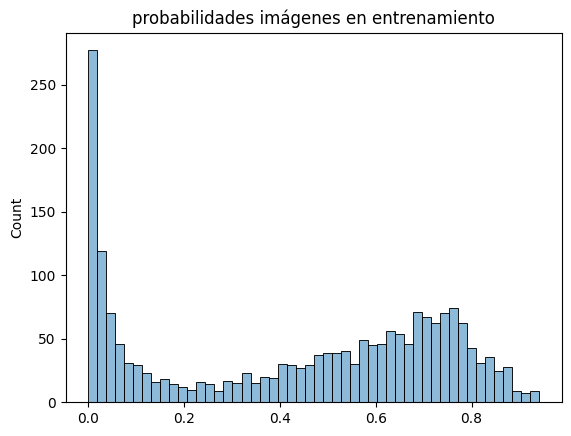

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

####probabilidades en evaluación para grupo 1 (tienen cancer de piel) #######
prob = best_rec.predict(X_test_cnn)
sns.histplot(prob, legend=False, bins=50)
plt.title("probabilidades imágenes en entrenamiento")### conocer el comportamiento de las probabilidades para revisar threshold



63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step
              precision    recall  f1-score   support

           0       1.00      0.43      0.60      1599
           1       0.30      1.00      0.47       404

    accuracy                           0.54      2003
   macro avg       0.65      0.71      0.53      2003
weighted avg       0.86      0.54      0.57      2003



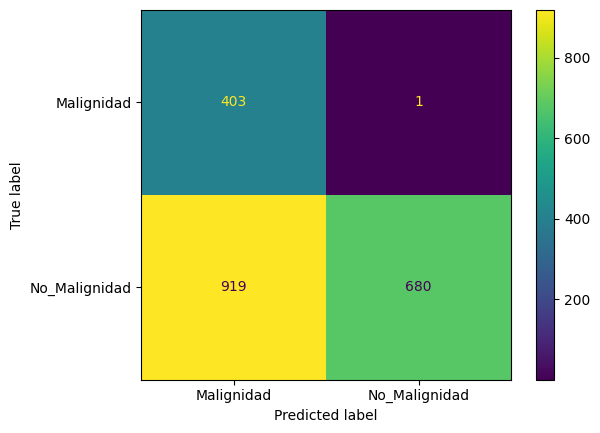

In [125]:
# Matriz de confusión test
pred_test = (best_rec.predict(X_test_cnn)>0.25).astype('int')
cm = metrics.confusion_matrix(y_test_cnn,pred_test, labels=[1,0])
disp = metrics.ConfusionMatrixDisplay(cm,display_labels=['Malignidad', 'No_Malignidad'])
disp.plot()

print(metrics.classification_report(y_test_cnn, pred_test))


In [127]:
prob = best_rec.predict(X_test_cnn)


clas = [
    'No Maligno' if prob < 0.25 else
    "No ident"
    for prob in prob
]
clases, count =np.unique(clas, return_counts=True)

count*100/np.sum(count)


63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step


array([33.9990015, 66.0009985])